In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import pickle
from numpy import unique
from numpy import random


from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn import cross_validation
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import linear_model


pd.set_option('display.max_column', 999)
pd.set_option('display.max_row', 999)

/Users/khrystynakosenko/anaconda/envs/py27/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Users/khrystynakosenko/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
df_merchants_old = pd.read_csv('/Users/khrystynakosenko/izettle/Data scienctist test/merchant_profile_old.csv')
df_trans_old = pd.read_csv('/Users/khrystynakosenko/izettle/Data scienctist test/transactions_old.csv')

In [4]:
df_merchants_old.head()

,customer_uuid,registration_timestamp,region,sales_channel,merchant_category
0,8252201a-9149-11e7-9552-9801a7abc7bf,2016-05-05 02:09:43,Latin America,Partnership,Retail
1,827afa1c-9149-11e7-aaac-9801a7abc7bf,2016-05-31 15:43:21,Europe,Online,Health Services
2,829e0250-9149-11e7-8c24-9801a7abc7bf,2015-08-22 15:48:02,Latin America,Online,Retail
3,82bd2980-9149-11e7-ab33-9801a7abc7bf,2016-05-13 02:05:36,Europe,Online,Food & Drink
4,82e79924-9149-11e7-83c4-9801a7abc7bf,2015-10-08 02:15:33,Europe,Online,Health Services


In [5]:
train = pd.merge(df_merchants_old, df_trans_old, on = 'customer_uuid')


# Making labels as profitable 

In [6]:
train.loc[(train.region == 'Latin America') & (train.sales_channel == 'Online'), 'expense'] = 47
train.loc[(train.region == 'Latin America') & (train.sales_channel == 'Partnership'), 'expense'] = 63
train.loc[(train.region == 'Latin America') & (train.sales_channel == 'Direct Sales'), 'expense'] = 89
train.loc[(train.region == 'Europe') & (train.sales_channel == 'Online'), 'expense'] = 69
train.loc[(train.region == 'Europe') & (train.sales_channel == 'Partnership'), 'expense'] = 83
train.loc[(train.region == 'Europe') & (train.sales_channel == 'Direct Sales'), 'expense'] = 103

In [7]:
train.head()

,customer_uuid,registration_timestamp,region,sales_channel,merchant_category,transaction_timestamp,amount_eur,expense
0,8252201a-9149-11e7-9552-9801a7abc7bf,2016-05-05 02:09:43,Latin America,Partnership,Retail,2016-06-02 11:39:53,6.168745,63.0
1,8252201a-9149-11e7-9552-9801a7abc7bf,2016-05-05 02:09:43,Latin America,Partnership,Retail,2016-06-02 14:00:47,9.114703,63.0
2,8252201a-9149-11e7-9552-9801a7abc7bf,2016-05-05 02:09:43,Latin America,Partnership,Retail,2016-06-02 16:44:18,5.125684,63.0
3,8252201a-9149-11e7-9552-9801a7abc7bf,2016-05-05 02:09:43,Latin America,Partnership,Retail,2016-06-02 21:24:36,18.967257,63.0
4,8252201a-9149-11e7-9552-9801a7abc7bf,2016-05-05 02:09:43,Latin America,Partnership,Retail,2016-11-01 13:50:20,15.334802,63.0


In [8]:
def transaction_sum(data):
    grouped= data.groupby('customer_uuid')['amount_eur'].sum()
    grouped = grouped.reset_index()
    result = pd.merge(data,grouped, on = ['customer_uuid'])
    print result.head()
    return result 

In [9]:
train_p = transaction_sum(train)

                          customer_uuid registration_timestamp         region  \
0  8252201a-9149-11e7-9552-9801a7abc7bf    2016-05-05 02:09:43  Latin America   
1  8252201a-9149-11e7-9552-9801a7abc7bf    2016-05-05 02:09:43  Latin America   
2  8252201a-9149-11e7-9552-9801a7abc7bf    2016-05-05 02:09:43  Latin America   
3  8252201a-9149-11e7-9552-9801a7abc7bf    2016-05-05 02:09:43  Latin America   
4  8252201a-9149-11e7-9552-9801a7abc7bf    2016-05-05 02:09:43  Latin America   

  sales_channel merchant_category transaction_timestamp  amount_eur_x  \
0   Partnership            Retail   2016-06-02 11:39:53      6.168745   
1   Partnership            Retail   2016-06-02 14:00:47      9.114703   
2   Partnership            Retail   2016-06-02 16:44:18      5.125684   
3   Partnership            Retail   2016-06-02 21:24:36     18.967257   
4   Partnership            Retail   2016-11-01 13:50:20     15.334802   

   expense  amount_eur_y  
0     63.0   7214.847977  
1     63.0   7214.84

In [10]:
profir_margin_L_A = 0.04
profir_margin_E = 0.02
train_p['profit'] = train_p['amount_eur_y'] * pd.np.where(train_p['region'] == 'Latin America', profir_margin_L_A, profir_margin_E)


In [11]:
train_p.head()

,customer_uuid,registration_timestamp,region,sales_channel,merchant_category,transaction_timestamp,amount_eur_x,expense,amount_eur_y,profit
0,8252201a-9149-11e7-9552-9801a7abc7bf,2016-05-05 02:09:43,Latin America,Partnership,Retail,2016-06-02 11:39:53,6.168745,63.0,7214.847977,288.593919
1,8252201a-9149-11e7-9552-9801a7abc7bf,2016-05-05 02:09:43,Latin America,Partnership,Retail,2016-06-02 14:00:47,9.114703,63.0,7214.847977,288.593919
2,8252201a-9149-11e7-9552-9801a7abc7bf,2016-05-05 02:09:43,Latin America,Partnership,Retail,2016-06-02 16:44:18,5.125684,63.0,7214.847977,288.593919
3,8252201a-9149-11e7-9552-9801a7abc7bf,2016-05-05 02:09:43,Latin America,Partnership,Retail,2016-06-02 21:24:36,18.967257,63.0,7214.847977,288.593919
4,8252201a-9149-11e7-9552-9801a7abc7bf,2016-05-05 02:09:43,Latin America,Partnership,Retail,2016-11-01 13:50:20,15.334802,63.0,7214.847977,288.593919


In [12]:
train_p.loc[train_p.profit > train_p.expense, 'label'] = 1
train_p.loc[train_p.profit < train_p.expense, 'label'] = 0

# Expoloring data

In [13]:
# General exploratory analysis. Done using Tableau

In [14]:
Image(filename='/Users/khrystynakosenko/Desktop/Screen Shot 2017-09-11 at 2.29.28 AM.png')

IOError: [Errno 2] No such file or directory: u'/Users/khrystynakosenko/Desktop/Screen Shot 2017-09-11 at 2.29.28 AM.png'

In [ ]:
Image(filename='/Users/khrystynakosenko/Desktop/Screen Shot 2017-09-11 at 2.35.26 AM.png')

# Preparing features

In [15]:
train_p.head()

,customer_uuid,registration_timestamp,region,sales_channel,merchant_category,transaction_timestamp,amount_eur_x,expense,amount_eur_y,profit,label
0,8252201a-9149-11e7-9552-9801a7abc7bf,2016-05-05 02:09:43,Latin America,Partnership,Retail,2016-06-02 11:39:53,6.168745,63.0,7214.847977,288.593919,1.0
1,8252201a-9149-11e7-9552-9801a7abc7bf,2016-05-05 02:09:43,Latin America,Partnership,Retail,2016-06-02 14:00:47,9.114703,63.0,7214.847977,288.593919,1.0
2,8252201a-9149-11e7-9552-9801a7abc7bf,2016-05-05 02:09:43,Latin America,Partnership,Retail,2016-06-02 16:44:18,5.125684,63.0,7214.847977,288.593919,1.0
3,8252201a-9149-11e7-9552-9801a7abc7bf,2016-05-05 02:09:43,Latin America,Partnership,Retail,2016-06-02 21:24:36,18.967257,63.0,7214.847977,288.593919,1.0
4,8252201a-9149-11e7-9552-9801a7abc7bf,2016-05-05 02:09:43,Latin America,Partnership,Retail,2016-11-01 13:50:20,15.334802,63.0,7214.847977,288.593919,1.0


              amount_eur_x   expense  amount_eur_y    profit     label
amount_eur_x      1.000000  0.192348      0.292032  0.235903  0.224270
expense           0.192348  1.000000      0.200229  0.086118  0.010101
amount_eur_y      0.292032  0.200229      1.000000  0.946591  0.374363
profit            0.235903  0.086118      0.946591  1.000000  0.384945
label             0.224270  0.010101      0.374363  0.384945  1.000000


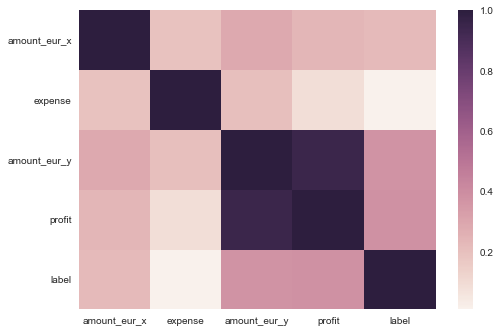

In [16]:

# calculate the correlation matrix
corr = train_p.corr()

print corr
# plot the heatmap
sns.heatmap(corr)

In [17]:

#will drop data for transaction time and money paid, since we have the total ammount of money that certain customer presented
#also will remove duplicates, since after removing transaction specific data having so many entries for each user is uselles
train = train_p.ix[:,
     ['customer_uuid', 'region', 'sales_channel', 'merchant_category', 
      'expense', 'profit', 'label']]

train.head()
train = train.drop_duplicates()
train = train.reset_index()
# print (train[train['label']==1]).count()
y = train.ix[:,'label']
train = train.ix[:,
     ['customer_uuid', 'region', 'sales_channel', 'merchant_category'
      ]]
label_encoder = preprocessing.LabelEncoder()
train['customer_uuid'] = label_encoder.fit_transform(train['customer_uuid'])
# train['expense'] = label_encoder.fit_transform(train['expense'])
# train['region'] = label_encoder.fit_transform(train['region'])
# train['sales_channel'] = label_encoder.fit_transform(train['sales_channel'])
# train['merchant_category'] = label_encoder.fit_transform(train['merchant_category'])
train = pd.get_dummies(train, columns=['region', 'sales_channel','merchant_category'])
print train.head()

features = train.columns
X = train.as_matrix().astype(np.float)


/Users/khrystynakosenko/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


   customer_uuid  region_Europe  region_Latin America  \
0           6156              0                     1   
1           6163              1                     0   
2           6172              0                     1   
3           6178              1                     0   
4           6187              1                     0   

   sales_channel_Direct Sales  sales_channel_Online  \
0                           0                     0   
1                           0                     1   
2                           0                     1   
3                           0                     1   
4                           0                     1   

   sales_channel_Partnership  merchant_category_Food & Drink  \
0                          1                               0   
1                          0                               0   
2                          0                               0   
3                          0                               1   
4     

/Users/khrystynakosenko/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [18]:
#Since we have highly unbalanced data, i will balance it.

def balanced_sample_maker(X, y, random_seed=None):
    """ return a balanced data set by oversampling minority class 
        current version is developed on assumption that the positive
        class is the minority.

    Parameters:
    ===========
    X: {numpy.ndarrray}
    y: {numpy.ndarray}
    """
    uniq_levels = unique(y)
    uniq_counts = {level: sum(y == level) for level in uniq_levels}

    if not random_seed is None:
        random.seed(random_seed)

    # find observation index of each class levels
    groupby_levels = {}
    for ii, level in enumerate(uniq_levels):
        obs_idx = [idx for idx, val in enumerate(y) if val == level]
        groupby_levels[level] = obs_idx

    # oversampling on observations of positive label
    sample_size = uniq_counts[0]
    over_sample_idx = random.choice(groupby_levels[1], size=sample_size, replace=True).tolist()
    balanced_copy_idx = groupby_levels[0] + over_sample_idx
    random.shuffle(balanced_copy_idx)

    return X[balanced_copy_idx, :], y[balanced_copy_idx]
X,y = balanced_sample_maker(X,y)

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [20]:
X

array([[ 0.97088468, -1.36006418,  1.36006418, ..., -0.5398473 ,
        -0.44765502, -0.55332297],
       [ 0.48920347,  0.73525942, -0.73525942, ...,  1.85237566,
        -0.44765502, -0.55332297],
       [-0.82625218,  0.73525942, -0.73525942, ..., -0.5398473 ,
        -0.44765502, -0.55332297],
       ..., 
       [-0.16618074,  0.73525942, -0.73525942, ..., -0.5398473 ,
        -0.44765502, -0.55332297],
       [-0.55273887, -1.36006418,  1.36006418, ..., -0.5398473 ,
        -0.44765502, -0.55332297],
       [-0.64538047, -1.36006418,  1.36006418, ..., -0.5398473 ,
         2.23386303, -0.55332297]])

In [ ]:
print "Features %d observations and %d features" % X.shape
print "Labels:", np.unique(y)

In [21]:
y= y.reset_index()
y = y.ix[:,'label']

/Users/khrystynakosenko/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


# Training model

In [22]:
# from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
def classifier(X, y, model_class, shuffle=True, n_folds=10, **kwargs):
    stratified_k_fold = cross_validation.StratifiedShuffleSplit(y, test_size=0.2, random_state=30)
    y_pred = y.copy()
    for ii, jj in stratified_k_fold:
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
#         print y_train.count()
#         print (y[y == 1].count())
#         print (y[y == 0].count())
        clf = model_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[jj] = clf.predict(X_test)
    return y_pred

In [ ]:
# print('Support vector machine(SVM): {:.2f}'.format(metrics.accuracy_score(y, classifier(X, y, SVC))))
print('Random Forest Classifier: {:.2f}'.format(metrics.accuracy_score(y, classifier(X, y, RandomForestClassifier, n_estimators=50))))
# print('K Nearest Neighbor Classifier: {:.2f}'.format(metrics.accuracy_score(y, classifier(X, y, KNeighborsClassifier))))
# print('Logistic Regression: {:.2f}'.format(metrics.accuracy_score(y, classifier(X, y, LogisticRegression, C=1.0))))
# C=10.0, gamma = 1.0, class_weight= 'balanced'
# print('SGDClassifier: {:.2f}'.format(metrics.accuracy_score(y, classifier(X, y, linear_model.SGDClassifier))))


In [ ]:
# find best parameter for n_estimators

scores = []

for val in range (1,50):
    m = RandomForestClassifier(n_estimators= val)
    v = cross_val_score(m, X, y, cv=10, scoring = 'f1')
    scores.append(v)
    

In [ ]:
#check accuracy, confusion matrix
svc = metrics.confusion_matrix(y, classifier(X, y, SVC))
RF = metrics.confusion_matrix(y, classifier(X, y, RandomForestClassifier, n_estimators=50))
LR = metrics.confusion_matrix(y, classifier(X, y, LogisticRegression))

In [ ]:
conf_matrix = {
                
                1: {
                    'matrix': svc,
                    'title': 'Support Vector Machine',
                   },
                2: {
                    'matrix': RF,
                    'title': 'Random Forest',
                   },
    
                
                3: {
                    'matrix': LR,
                    'title': 'Logistic Regression',
                   }
                
}

In [ ]:

fix, ax = plt.subplots(figsize=(19, 16))

plt.suptitle('Confusion Matrix ')
for i, values in conf_matrix.items():
    matrix = values['matrix']
    title = values['title']
    plt.subplot(2, 2, i) # starts from 1
    plt.title(title);
    sns.heatmap(matrix, annot=True,  fmt='');

In [23]:
#training the best model

stratified_k_fold = cross_validation.StratifiedShuffleSplit(y, test_size=0.2, random_state=30)
for ii, jj in stratified_k_fold:
    X_train, X_test = X[ii], X[jj]
    y_train = y[ii]
    best_clf = RandomForestClassifier(n_estimators=50)
    best_clf.fit(X_train,y_train)
    

In [24]:
df_test = pd.read_csv('/Users/khrystynakosenko/izettle/Data scienctist test/merchant_profile_new.csv')

test = df_test.ix[:,
     ['customer_uuid', 'region', 'sales_channel', 'merchant_category', 
      ]]

test.head()
test = test.drop_duplicates()
test = test.reset_index()
# print (test[test['label']==1]).count()
test = test.ix[:,
     ['customer_uuid', 'region', 'sales_channel', 'merchant_category'
      ]]
label_encoder = preprocessing.LabelEncoder()
test['customer_uuid'] = label_encoder.fit_transform(test['customer_uuid'])
test = pd.get_dummies(test, columns=['region', 'sales_channel','merchant_category'])


# features = test.columns
# X_test1 = test.as_matrix().astype(np.float)
# print len(X_test1)
# X_test1 = scaler.fit_transform(X)
# print len(X_test1)


/Users/khrystynakosenko/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  app.launch_new_instance()
/Users/khrystynakosenko/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [338]:
#save model
s = pickle.dumps(best_clf)
clf2 = pickle.loads(s)

In [1]:

df_test['profitable'] = best_clf.predict(test)

NameError: name 'best_clf' is not defined

In [25]:
from ggplot import *


print('Random Forest Classifier: {:.2f}'.format(metrics.accuracy_score(y, classifier(X, y, RandomForestClassifier, n_estimators=50))))
stratified_k_fold = cross_validation.StratifiedShuffleSplit(y, test_size=0.2, random_state=30)
for ii, jj in stratified_k_fold:
    X_train, X_test = X[ii], X[jj]
    y_train = y[ii]
    best_clf = RandomForestClassifier(n_estimators=50)
    best_clf.fit(X_train,y_train)

preds = best_clf.predict(test)
fpr, tpr, _ = metrics.roc_curve(ytest, preds)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

ImportError: No module named ggplot

In [ ]:
df_test.head()

In [ ]:
df_test.to_csv('/Users/khrystynakosenko/izettle/Data scienctist test/merchant_profile_new.csv')